<a href="https://colab.research.google.com/github/tonytarizzo/paddyRiceCompetition/blob/main/paddyCompetition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai
!pip install timm

try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *
from fastai.vision.all import*
import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.5 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
comp = 'paddy-disease-classification'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

100%|██████████| 1.02G/1.02G [00:53<00:00, 20.3MB/s]


In [5]:
path


Path('paddy-disease-classification')

In [6]:
from fastai.vision.all import *
set_seed(42)

path.ls()

(#4) [Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/train_images'),Path('paddy-disease-classification/train.csv'),Path('paddy-disease-classification/test_images')]

In [7]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

(480, 640)


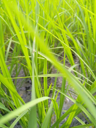

In [8]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [9]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

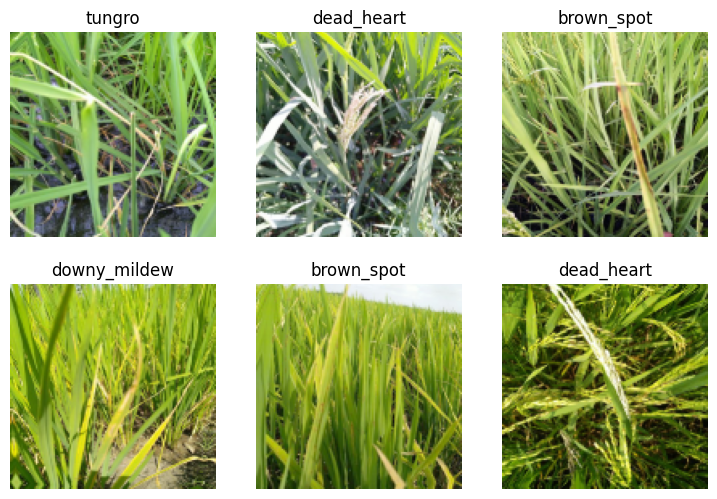

In [10]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

In [11]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

SuggestedLRs(valley=0.0014454397605732083, slide=0.005248074419796467)

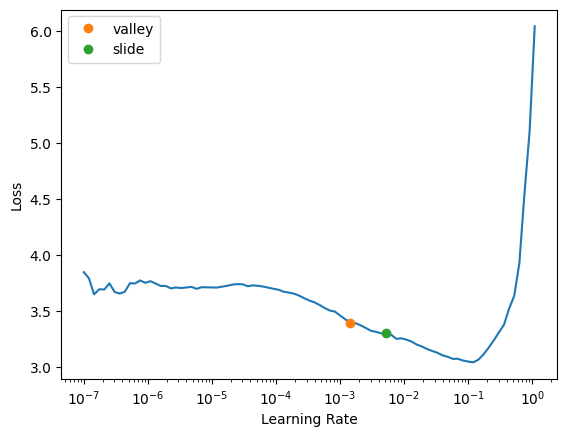

In [12]:
learn.lr_find(suggest_funcs=(valley, slide))

In [13]:
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.797971,1.258445,0.402210,01:23


epoch,train_loss,valid_loss,error_rate,time
0,1.162442,0.727637,0.242191,01:21
1,0.796089,0.443582,0.137914,01:22
2,0.549670,0.383783,0.108121,01:21


In [14]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [15]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

In [16]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

tensor([7, 8, 7,  ..., 8, 1, 5])

In [17]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [18]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                       hispa
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [19]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,hispa
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [22]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'initial rn26d 128px', comp)

100%|██████████| 70.3k/70.3k [00:02<00:00, 30.6kB/s]
